In [1]:
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot as plt
import csv

In [34]:
"""
create commit frequency dataset
"""

commits = pd.read_csv("data/commits.csv")
commits["timestamp"] = pd.to_datetime(commits["timestamp"], unit="s")
commits_grouped = commits.groupby(["project", "timestamp"]).count()
commits_grouped = commits_grouped.reset_index()
commits_grouped = commits_grouped.set_index("timestamp")

projects = sorted(commits_grouped["project"].unique())

combined = DataFrame()
for project in projects:
    # set resolution of 2 weeks
    frequency = commits_grouped[commits_grouped["project"] == project].resample("14d").sum()
    frequency = frequency.rename(columns={"commit_hash": "commits_per_14days"})
    frequency["project"] = project
    combined = pd.concat([combined, frequency])

combined.to_csv("data/commit_frequency_14d.csv")



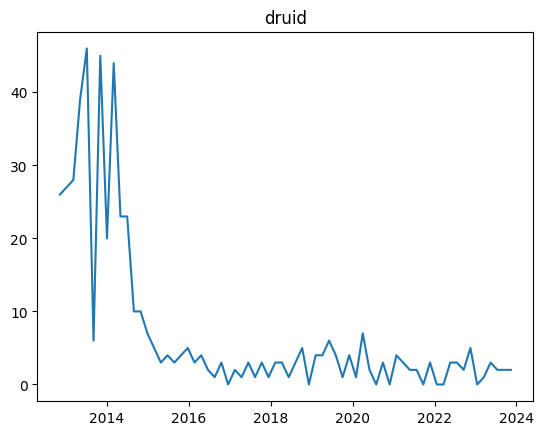

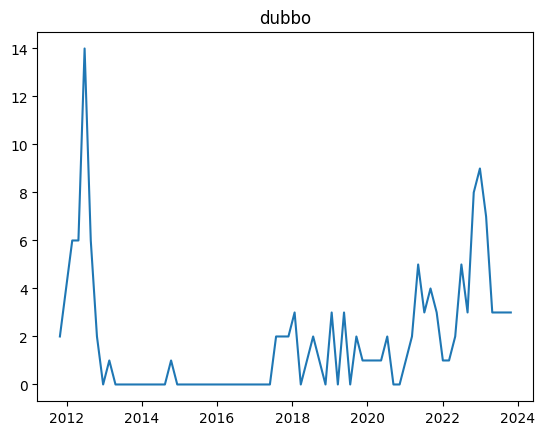

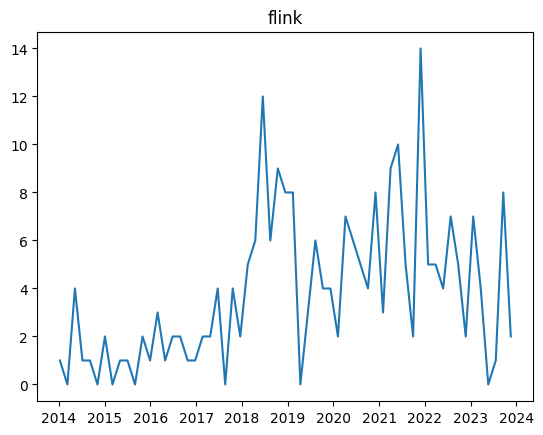

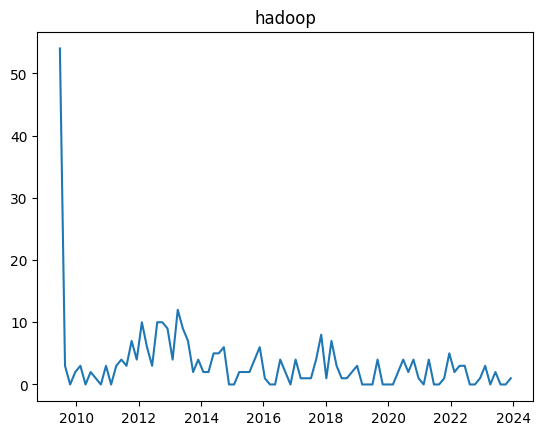

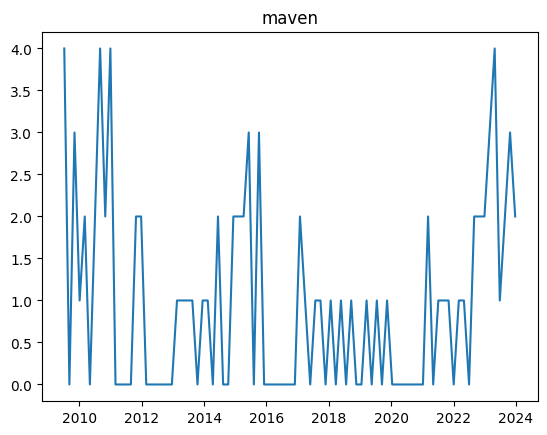

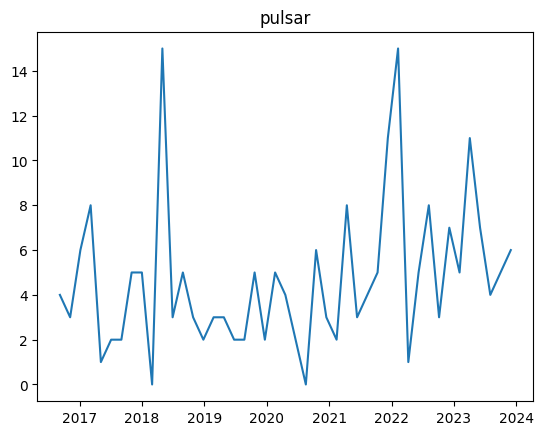

In [36]:
from pandas import DataFrame

"""
create release frequency dataset
"""

commits = pd.read_csv("data/releases.csv")
commits["timestamp"] = pd.to_datetime(commits["timestamp"], unit="s")
commits_grouped = commits.groupby(["project", "timestamp"]).count()
commits_grouped = commits_grouped.reset_index()
commits_grouped = commits_grouped.set_index("timestamp")

projects = sorted(commits_grouped["project"].unique())
combined = DataFrame()

for project in projects:
    # set resolution of 2 weeks
    frequency = commits_grouped[commits_grouped["project"] == project].resample("60d").sum()
    frequency = frequency.rename(columns={"release_name": "releases_per_60days"})
    frequency["project"] = project
    combined = pd.concat([combined, frequency])
    frequency.reset_index(inplace=True)
    plt.plot(frequency["timestamp"], frequency["releases_per_60days"])
    plt.title(project)
    plt.show()

combined.to_csv("data/release_frequency_60d.csv")

In [34]:
"""
merge all to master dataset
"""

satds = pd.read_csv("data/satds.csv")

satds["total"] = satds["code|design-debt"] + satds["test-debt"] + satds["documentation-debt"] + satds[
    "requirement-debt"]

commit_frequency = pd.read_csv("data/commit_frequency_14d.csv")
release_frequency = pd.read_csv("data/release_frequency_60d.csv")
prs = pd.read_csv("data/prs-aggregated.csv")
prs_per_7 = pd.read_csv("data/prs-per-7days.csv")

satds["timestamp"] = pd.to_datetime(satds["timestamp"], unit="s")

commit_frequency["timestamp"] = pd.to_datetime(commit_frequency["timestamp"])
release_frequency["timestamp"] = pd.to_datetime(release_frequency["timestamp"])
prs["timestamp"] = pd.to_datetime(prs["timestamp"]).dt.tz_localize(None)
prs_per_7["timestamp"] = pd.to_datetime(prs_per_7["timestamp"]).dt.tz_localize(None)


combined = DataFrame()
for project in sorted(satds["project"].unique()):
    selection_satds = satds[satds["project"] == project].sort_values("timestamp")
    selection_commit_frequency = commit_frequency[commit_frequency["project"] == project].sort_values("timestamp")
    selection_release_frequency = release_frequency[release_frequency["project"] == project].sort_values("timestamp")
    selection_prs = prs[prs["project"] == project].sort_values("timestamp")
    selection_prs_per_7 = prs_per_7[prs_per_7["project"] == project].sort_values("timestamp")

    merged = pd.merge_asof(selection_satds, selection_commit_frequency[["timestamp", "commits_per_14days"]], on="timestamp")
    merged = pd.merge_asof(merged, selection_release_frequency[["timestamp", "releases_per_60days"]], on="timestamp")
    merged = pd.merge_asof(merged, selection_prs[["timestamp", "cumsum"]], on="timestamp")
    merged.rename(columns={"cumsum": "open_prs_exact"}, inplace=True)
    merged = pd.merge_asof(merged, selection_prs_per_7[["timestamp", "open_prs"]], on="timestamp")
    merged.rename(columns={"open_prs": "open_prs_per7"}, inplace=True)

    combined = pd.concat([combined, merged])
# 
combined.set_index("timestamp", inplace=True)
combined.to_csv("data/master-dataset.csv")
combined





,project,code|design-debt,requirement-debt,documentation-debt,test-debt,total,commits_per_14days,releases_per_60days,open_prs_exact,open_prs_per7
timestamp,,,,,,,,,,
2012-10-24 07:39:51,druid,37,3,0,0,40,55,NaN,NaN,0.0
2012-10-24 09:09:47,druid,532,0,0,0,532,55,NaN,NaN,0.0
2012-10-29 21:34:17,druid,1,0,0,0,1,55,NaN,0.0,0.0
2012-10-29 23:04:13,druid,1,0,0,0,1,55,NaN,0.0,0.0
2012-10-31 21:35:09,druid,8,0,0,0,8,55,NaN,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-13 02:21:11,pulsar,0,1,0,0,1,77,6.0,298.0,-5.0
2023-12-14 03:50:37,pulsar,1,0,0,0,1,77,6.0,296.0,-5.0
2023-12-15 17:23:23,pulsar,1,0,0,0,1,77,6.0,292.0,-5.0


In [115]:
with open("data/prs.csv", mode="w") as file:
    writer = csv.writer(file)
    writer.writerow(["timestamp", "project", "open_prs"])

    for project in ["druid", "dubbo", "flink", "hadoop", "maven", "pulsar"]:
        df = pd.read_csv(f"data/prs_reduced/{project}.csv")
        df["created_at"] = pd.to_datetime(df["created_at"])
        df["closed_at"] = pd.to_datetime(df["closed_at"])

        timestamps = sorted(pd.concat([df["created_at"], df["closed_at"]]).dropna().unique())
        for timestamp in timestamps:
            counter = 0
            counter += len(df[df["created_at"] == timestamp])
            counter -= len(df[df["closed_at"] == timestamp])
            writer.writerow([timestamp, project, counter])


In [117]:
"""
cumulate per project
"""

df = pd.read_csv("data/prs.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

combined = DataFrame()
frequency = DataFrame()
for project in df["project"].unique():
    project_df = df[df["project"] == project]
    project_df = project_df.sort_values("timestamp")
    project_df["cumsum"] = project_df["open_prs"].cumsum()

    combined = pd.concat([combined, project_df])
    resampled = project_df.resample("7d").sum()
    resampled["project"] = project
    # resampled.reset_index(inplace=True)
    frequency = pd.concat([frequency, resampled])

    # plt.title(project)
    # plt.plot(resampled["timestamp"], resampled["open_issues"])
    # plt.show()

combined.to_csv("data/prs-aggregated.csv")
frequency.rename(columns={"open_prs": "open_prs_per_7days"})
frequency.to_csv("data/prs-per-7days.csv")


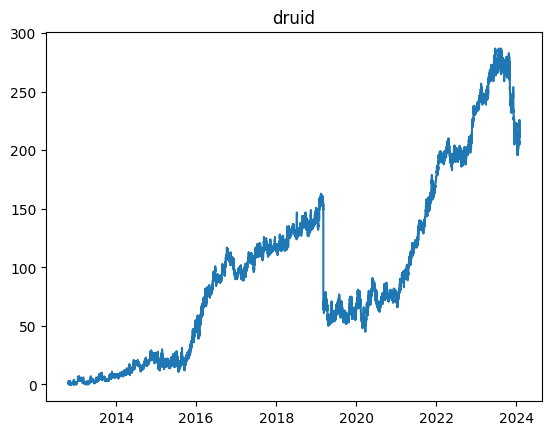

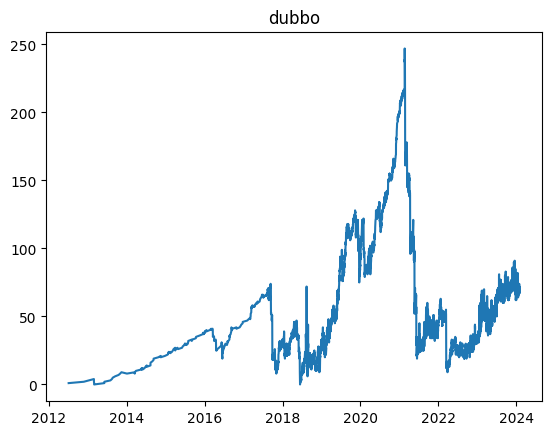

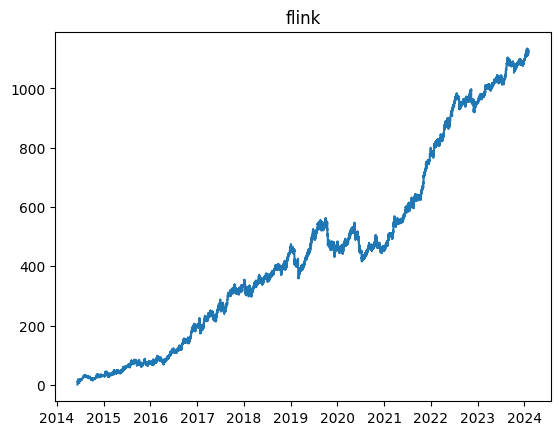

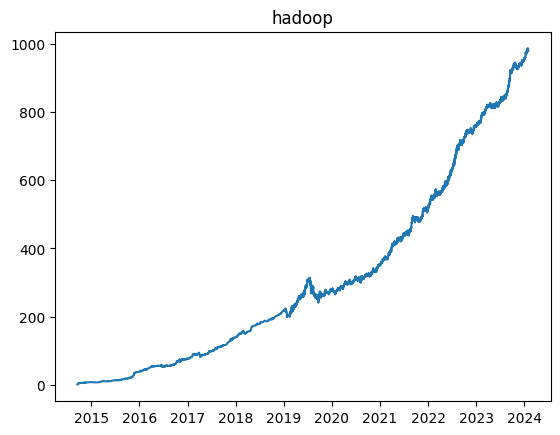

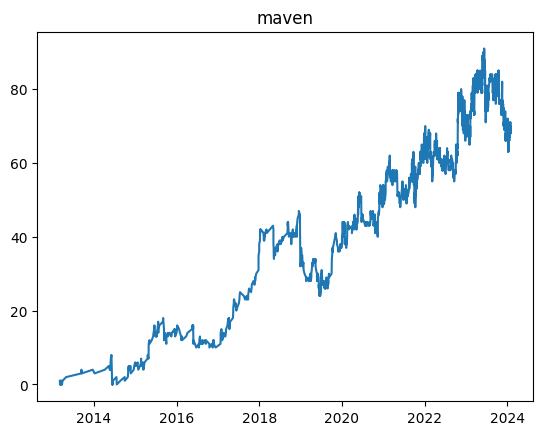

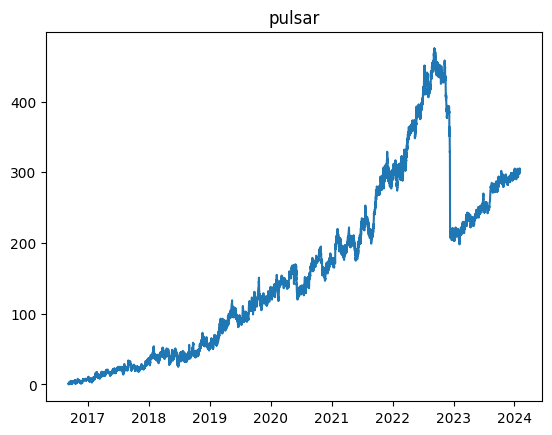

In [6]:
df = pd.read_csv("data/prs-aggregated.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])

for project in df["project"].unique():
    project_df = df[df["project"] == project]

    plt.title(project)
    plt.plot(project_df["timestamp"], project_df["open_prs"].cumsum())
    plt.show()


In [30]:
project = "pulsar"
df = pd.read_csv(f"data/pull_requests/{project}.csv",
                 names=["id", "title", "body", "status", "created_at", "closed_at", "merged_at"])
df = df[["id", "created_at", "closed_at"]]
df.set_index("id").to_csv(f"data/prs_reduced/{project}.csv")

In [ ]:
master_df = pd.read_csv("data/master-dataset.csv")
prs_df = pd.read_csv("data/prs-aggregated.csv")
prs_per_7_df = pd.read_csv("data/prs-per-7days.csv")

master_df["timestamp"] = pd.to_datetime(master_df["timestamp"])
prs_df["timestamp"] = pd.to_datetime(prs_df["timestamp"])
prs_per_7_df["timestamp"] = pd.to_datetime(prs_per_7_df["timestamp"])

for project in master_df["project"].unique():
    project_master_df = master_df[master_df["project"] == project]
    project__df = master_df[master_df["project"] == project]

    
